# Random Sampling and Q-Learning

Here, we randomly sample reward sequences and simulate participants via q-learning agents in a two-armed-bandit task.
We also use the state mechanic of the AutoRA package.

### Sampler
The sampler creates random reward sequences with an initial reward probabilities and change sampled from a gaussian distribution. The reward sequences are independent for each arm of the bandit task.

## Install

In [26]:
# Uncomment the following line when running on Google Colab
# !pip install autora
# !pip install autora-experimentalist-bandit-random
# !pip install autora-theorist-rnn-sindy-rl
# !pip install matplotlib

## Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# General AutoRA
from autora.variable import VariableCollection, Variable
from autora.state import StandardState, on_state, Delta

# Experimentalists
from autora.experimentalist.bandit_random import bandit_random_pool

# Experiment Runner
from autora.experiment_runner.synthetic.psychology.q_learning import q_learning

# Theorist
from autora.theorist.rnn_sindy_rl import RNNSindy
from autora.theorist.rnn_sindy_rl.utils.parse import parse

import numpy as np

## Constants


In [28]:
TRIALS_PER_PARTICIPANTS = 100
SAMPLES_PER_CYCLE = 1
PARTICIPANTS_PER_CYCLE = 40
CYCLES = 2
INITIAL_REWARD_PROBABILITY_RANGE = [.2, .8]  # Range to sample from for the initial reward probability
SIGMA_RANGE = [.2, .2] # Range to sample for the sigma of the gaussian distribution for the change

EPOCHS = 100

## Variables

To define our experiment, we first setup the independent and dependent variables:

independent variable is "reward-trajectory": A 2 x n_trials Vector with entries between 0 and 1
dependent variable is "choice-trajectory": A 2 x n_trials Vector with boolean entries (one hot encoded)

In [29]:
variables = VariableCollection(
    independent_variables=[Variable(name="reward-trajectory")],
    dependent_variables=[Variable(name="choice-trajectory")]
)

## State
We initialize a StandardState with the variablse

In [30]:
state = StandardState(variables=variables)

## Components
### Experimentalist: Random Pool

We use the sampler provided in `autora-experimentalist-bandit-random` and wrap it with the on_state functionality.
Here, we use ranomly sample one condition and use it for `PARTICIPANT_PER_CYCLE`-number of participant 


In [31]:
@on_state()
def pool_on_state(num_samples, n_trials=TRIALS_PER_PARTICIPANTS):
    """
    This is creates `num_samples` randomized reward trajectories of length `n_trials`
    """
    # sample sigma
    sigma = np.random.uniform(SIGMA_RANGE[0], SIGMA_RANGE[1])
    # create a reward-trajectory
    _trajectory_array = bandit_random_pool(
        num_rewards=2,
        sequence_length=n_trials,
        initial_probabilities=[INITIAL_REWARD_PROBABILITY_RANGE, INITIAL_REWARD_PROBABILITY_RANGE],
        sigmas=[sigma, sigma],
        num_samples=num_samples
    )
    # Duplicate the same condition `PARTICIPANT_PER_CYCLE` times:
    trajectory_array = [_trajectory_array[0] for _ in range(PARTICIPANTS_PER_CYCLE)]
    # Convert the list into a pandas dataFrame. The column name is the same as the name of the independent variable
    trajectory_df = pd.DataFrame({'reward-trajectory': trajectory_array})
    return Delta(conditions=trajectory_df)

### Runner: Q-Learning

We use a q-learning runner from the `autora-synthetic-q-learning` package to simulate data on the created condition.

In [32]:
runner = q_learning()

@on_state()
def runner_on_state(conditions):
    choices, choice_probabilities = runner.run(conditions, return_choice_probabilities=True)
    experiment_data = pd.DataFrame({
        'reward-trajectory': conditions['reward-trajectory'].tolist(),
        'choice-trajectory': choices,
        'choice-probability-trajectory': choice_probabilities
    })
    return Delta(experiment_data=experiment_data)

### Theorist: RNNSindy

We initilize the theorist and wrap it to run on state: 

In [33]:
theorist = RNNSindy(2, epochs=EPOCHS)

@on_state()
def theorist_on_state(experiment_data):
    x = np.stack(experiment_data['reward-trajectory'].tolist())
    y = np.stack(experiment_data['choice-trajectory'].tolist())
    return Delta(models=[theorist.fit(x, y)])

## Cycle
After defining the components, we can run them (here, in a cycle):

In [34]:
for c in range(1, CYCLES + 1):
    print(f'Starting Cycle {c}')
    # Creating conditions:
    state = pool_on_state(state, num_samples=SAMPLES_PER_CYCLE)
    # Creating experiment_data:
    state = runner_on_state(state)
    # Creating a model:
    state = theorist_on_state(state)

Starting Cycle 1
Training the RNN...
Epoch 1/100 --- Loss: 0.5434861; Time: 0.5098s; Convergence value: 4.57e-01
Epoch 2/100 --- Loss: 0.4197326; Time: 0.5370s; Convergence value: 2.88e-01
Epoch 3/100 --- Loss: 0.5376319; Time: 0.4743s; Convergence value: 2.29e-01
Epoch 4/100 --- Loss: 0.4316915; Time: 0.5265s; Convergence value: 1.97e-01
Epoch 5/100 --- Loss: 0.3979543; Time: 0.4942s; Convergence value: 1.62e-01
Epoch 6/100 --- Loss: 0.4797593; Time: 0.5633s; Convergence value: 1.48e-01
Epoch 7/100 --- Loss: 0.3964677; Time: 0.5096s; Convergence value: 1.38e-01
Epoch 8/100 --- Loss: 0.4296828; Time: 0.5303s; Convergence value: 1.23e-01
Epoch 9/100 --- Loss: 0.4576994; Time: 0.4579s; Convergence value: 1.11e-01
Epoch 10/100 --- Loss: 0.3761841; Time: 0.4692s; Convergence value: 1.07e-01
Epoch 11/100 --- Loss: 0.4348626; Time: 0.4520s; Convergence value: 1.02e-01
Epoch 12/100 --- Loss: 0.4520413; Time: 0.4565s; Convergence value: 9.35e-02
Epoch 13/100 --- Loss: 0.4251168; Time: 0.4542s;

## Plotting the Data and Predictions


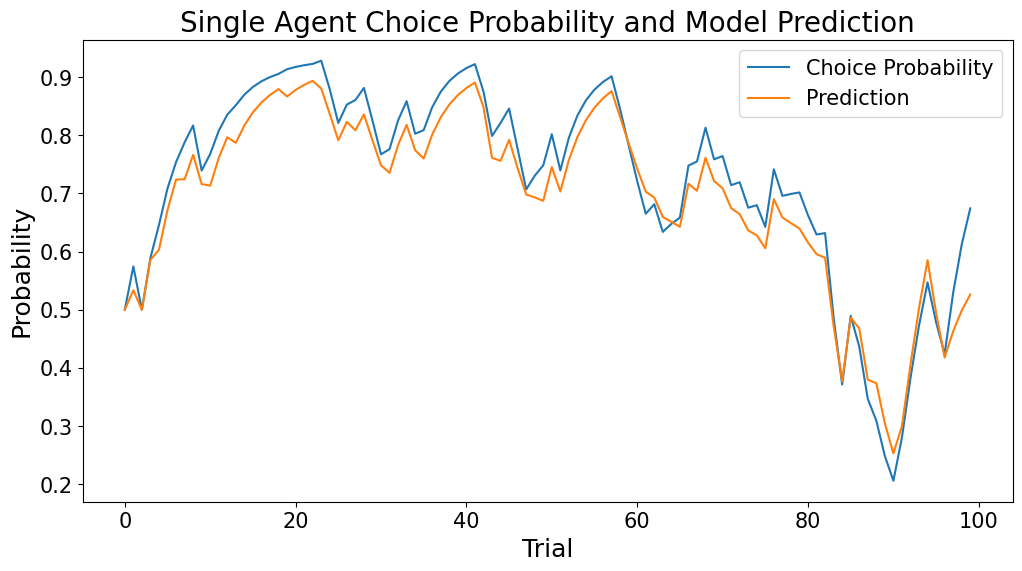

In [35]:
model = state.models[-1]
exp_data = state.experiment_data
    
single_agent_choice_probability = np.array(
        exp_data['choice-probability-trajectory'].tolist()[-1])
single_agent_choices = np.array(exp_data['choice-trajectory'].tolist()[-1])
single_agent_rewards = np.array(exp_data['reward-trajectory'].tolist()[-1])
y_pred_single = np.array(
        model.predict([single_agent_rewards], observations=[single_agent_choices])).reshape(
        TRIALS_PER_PARTICIPANTS, 2)
y_pred_list = [y[0] for y in y_pred_single]

fig, ax = plt.subplots(figsize=(12, 6))
# plot:
ax.plot(range(TRIALS_PER_PARTICIPANTS), single_agent_choice_probability[:,0], label='Choice Probability')

ax.plot(range(TRIALS_PER_PARTICIPANTS), y_pred_list, label='Prediction')

# Labels and title
ax.set_xlabel('Trial')
ax.set_ylabel('Probability')
ax.set_title('Single Agent Choice Probability and Model Prediction')

# Legend
ax.legend()

# Display the plot
plt.show()

## Discovered Learning Equation

In [36]:
equations = (parse(model))

eq_chosen = equations[0]
eq_non_chosen = equations[1]


print(eq_chosen)
print(eq_non_chosen)


Disovered model:
Q_{chosen,}_{t+1}=0.182*Reward + 0.823*Q_{chosen,}_{t}
Q_{not chosen,}_{t+1}=0.955*Q_{not chosen,}_{t}
